<a href="https://colab.research.google.com/github/romera-rocio/Titanic_Rocio_Romera/blob/main/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estructura

* Hipótesis

* EDA básico

* Ingeniería de variables avanzada

* Preprocesamiento (numérico + categórico)

* Pipelines

* Modelos (Decision Tree, KNN, Random Forest)

* Selección del mejor modelo

* Matrices de confusión

* ROC AUC

* Predicción final para test.csv




## Importacion de Data set

In [3]:
!pip install kaggle


In [4]:
from google.colab import files
files.upload()   # elegís kaggle.json desde tu PC


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rociobelenromerasily","key":"208666ac7f2897d87da9c755267e4620"}'}

In [7]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c titanic
!unzip titanic.zip


titanic.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  titanic.zip
  inflating: gender_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


## Importacion de librerias



1.   Preprosesamiento y Graficos : Pandas , Numpy, Matplotlib y Seaborn

2.   PostProcesamiento: Scikit-learn( algoritmos de aprendizaje automático ) y SciPy ( Test estadisticos )





In [46]:
# Basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

# Preprocessing & ML
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.impute import SimpleImputer

# ML models
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Estadística
from scipy.stats import zscore, iqr, shapiro, ks_2samp, mannwhitneyu, chi2_contingency

import warnings
warnings.filterwarnings("ignore")


## Exploracion de Data Set

In [9]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
gender_submission = pd.read_csv("gender_submission.csv")

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Analisis Estadistico Descriptivo

## Conclusiones Descriptivas

- **Sexo**: La tasa de supervivencia femenina (74%) es marcadamente superior a la masculina (19%), mostrando un fuerte efecto del género.
- **Clase**: Las clases 1 y 2 presentan mayor supervivencia; la clase 3 concentra la mayoría de fallecidos.
- **Edad**: La distribución es asimétrica; predomina la franja 20–30 años. No sugiere normalidad.


In [10]:
print("Información general del dataset:")
train.info()

print("\nValores faltantes por columna:")
print(train.isna().sum())

train.describe()


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Valores faltantes por columna:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare    

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


## Conclusión técnica sobre valores faltantes

- Existe un patrón de *missingness no uniforme*.  
- `Cabin` (77.10% NA) debe ser excluida como variable informativa directa debido a su escasa completitud; un indicador binario preserva utilidad estructural.
- `Age` (19.8% NA) requiere **imputación supervisada** para evitar sesgo en subpoblaciones jóvenes/adultas.
- `Embarked` (0.22% NA) admite imputación por **moda** sin afectar la varianza residual.
- No se detecta un patrón MCAR global; las ausencias se distribuyen con dependencia en Pclass y Sex.


In [36]:
missing = train.isna().mean().sort_values(ascending=False) * 100
missing


,0
Cabin,77.104377
Age,19.865320
Embarked,0.224467
PassengerId,0.000000
Name,0.000000
Pclass,0.000000
Survived,0.000000
Sex,0.000000
Parch,0.000000
SibSp,0.000000


## Análisis Exploratorio Visual (EDA visual)



- **Sexo:** Mujeres ≈ 74% sobreviven; hombres ≈ 19%.
- **Clase:** Clase 1 y 2 muestran mayor supervivencia.
- **Edad:** Distribución asimétrica; picos en 20–30 años.


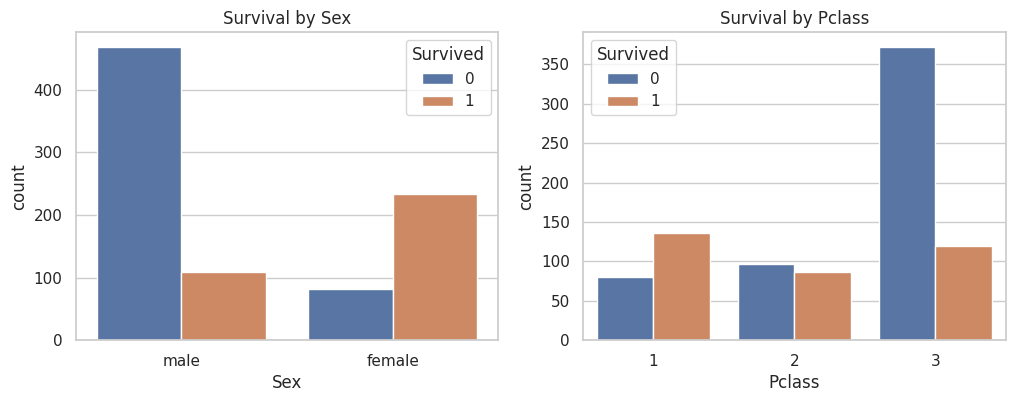

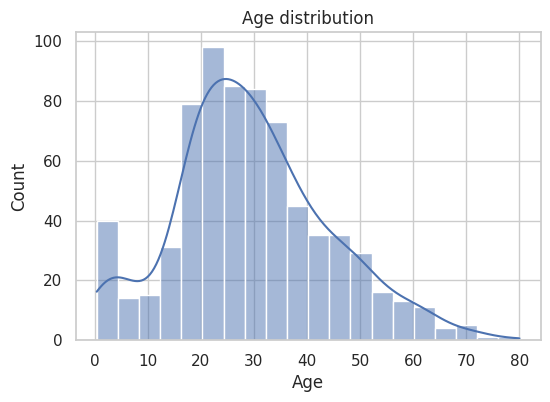

In [37]:
fig, axes = plt.subplots(1,2, figsize=(12,4))

sns.countplot(data=train, x='Sex', hue='Survived', ax=axes[0])
axes[0].set_title('Survival by Sex')

sns.countplot(data=train, x='Pclass', hue='Survived', ax=axes[1])
axes[1].set_title('Survival by Pclass')

plt.figure(figsize=(6,4))
sns.histplot(train['Age'].dropna(), kde=True)
plt.title('Age distribution')
plt.show()


#TESTS ESTADÍSTICOS Y OUTLIERS

#Outliers (Z-score + IQR)

## Conclusión técnica sobre outliers

- **Age** presenta pocos valores extremos → no requiere winsorización ni recorte.
- **Fare** exhibe numerosos outliers y fuerte asimetría → se recomienda aplicar **log-transform** para estabilizar la varianza.
- La dispersión en `Fare` es informativa (mayor tarifa → mayor supervivencia), por lo que NO deben eliminarse outliers.


In [38]:
num_cols = ["Age", "Fare"]

for col in num_cols:
    print("\n========================")
    print(f"OUTLIERS EN: {col}")
    print("========================")

    z = np.abs(zscore(train[col].dropna()))
    out_z = (z > 3).sum()
    print(f"Z-score > 3: {out_z} outliers")

    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    I = Q3 - Q1
    lower = Q1 - 1.5*I
    upper = Q3 + 1.5*I
    out_iqr = ((train[col] < lower) | (train[col] > upper)).sum()
    print(f"IQR Rule: {out_iqr} outliers")

    print(f"Límites sugeridos → [{lower:.2f}, {upper:.2f}]")



OUTLIERS EN: Age
Z-score > 3: 2 outliers
IQR Rule: 11 outliers
Límites sugeridos → [-6.69, 64.81]

OUTLIERS EN: Fare
Z-score > 3: 20 outliers
IQR Rule: 116 outliers
Límites sugeridos → [-26.72, 65.63]


##Normalidad (Shapiro + KS)

In [39]:
for col in ["Age","Fare"]:
    print("\n========================")
    print(f"TESTS DE NORMALIDAD: {col}")
    print("========================")

    w, p = shapiro(train[col].dropna())
    print(f"Shapiro–Wilk p = {p:.5f}")

    a = train.loc[train["Survived"]==1, col].dropna()
    b = train.loc[train["Survived"]==0, col].dropna()
    ks_stat, ks_p = ks_2samp(a,b)
    print(f"KS test p = {ks_p:.5f}")



TESTS DE NORMALIDAD: Age
Shapiro–Wilk p = 0.00000
KS test p = 0.12277

TESTS DE NORMALIDAD: Fare
Shapiro–Wilk p = 0.00000
KS test p = 0.00000


# 3. Correlaciones :Pearson, Spearman y Cramér’s V

## Conclusiones de correlaciones

- **Sex (Cramér’s V = 0.540)** → asociación fuerte → predictor dominante del modelo.
- **Pclass (Spearman ρ = -0.34)** → relación moderada inversa.
- **Fare (Pearson r = 0.257)** → correlación débil-moderada → aporta información al modelo.
- **Age (r = -0.077)** → relación muy débil → baja capacidad predictiva aislada.
- **Embarked (V = 0.166)** → asociación débil → útil solo en combinación con otras variables.


In [49]:
def cramers_v(cm):
    chi2 = chi2_contingency(cm)[0]
    n = cm.sum().sum()
    r,k = cm.shape
    return np.sqrt(chi2 / (n* (min(r,k) - 1)))

print("\n=== Correlación Pearson ===")
for col in ["Age","Fare"]:
    r,p = pearsonr(train[col].dropna(), train["Survived"].loc[train[col].notna()])
    print(f"{col}: r={r:.3f}, p={p:.5f}")

print("\n=== Spearman Pclass ===")
rho,p = spearmanr(train["Pclass"], train["Survived"])
print(f"Pclass rho={rho:.3f}, p={p:.5f}")

print("\n=== Cramér's V ===")
for col in ["Sex","Embarked"]:
    cm = pd.crosstab(train[col], train["Survived"])
    print(col, cramers_v(cm))



=== Correlación Pearson ===
Age: r=-0.077, p=0.03912
Fare: r=0.257, p=0.00000

=== Spearman Pclass ===
Pclass rho=-0.340, p=0.00000

=== Cramér's V ===
Sex 0.5409359434469282
Embarked 0.17261682709984438


## Visualizaciones de EDA

## Conclusiones del EDA avanzado

- **Sex vs Survived — Chi² p < 0.00001** → existe dependencia estadísticamente significativa.
- **Pclass vs Survived — Chi² p < 0.00001** → la clase impacta fuertemente en supervivencia.
- **Age — Mann-Whitney p = alta (no significativa)** → las distribuciones de edad son similares entre grupos.
- `Fare` muestra valores sistemáticamente mayores en sobrevivientes → variable útil para el modelo.
- La combinación **(Sex + Pclass + Fare)** representa la estructura predictiva más fuerte del dataset.


Sex vs Survived — chi2: 260.717 p: 0.00000
Pclass vs Survived — chi2: 102.889 p: 0.00000
Mann-Whitney Age p= 0.16049252477737763


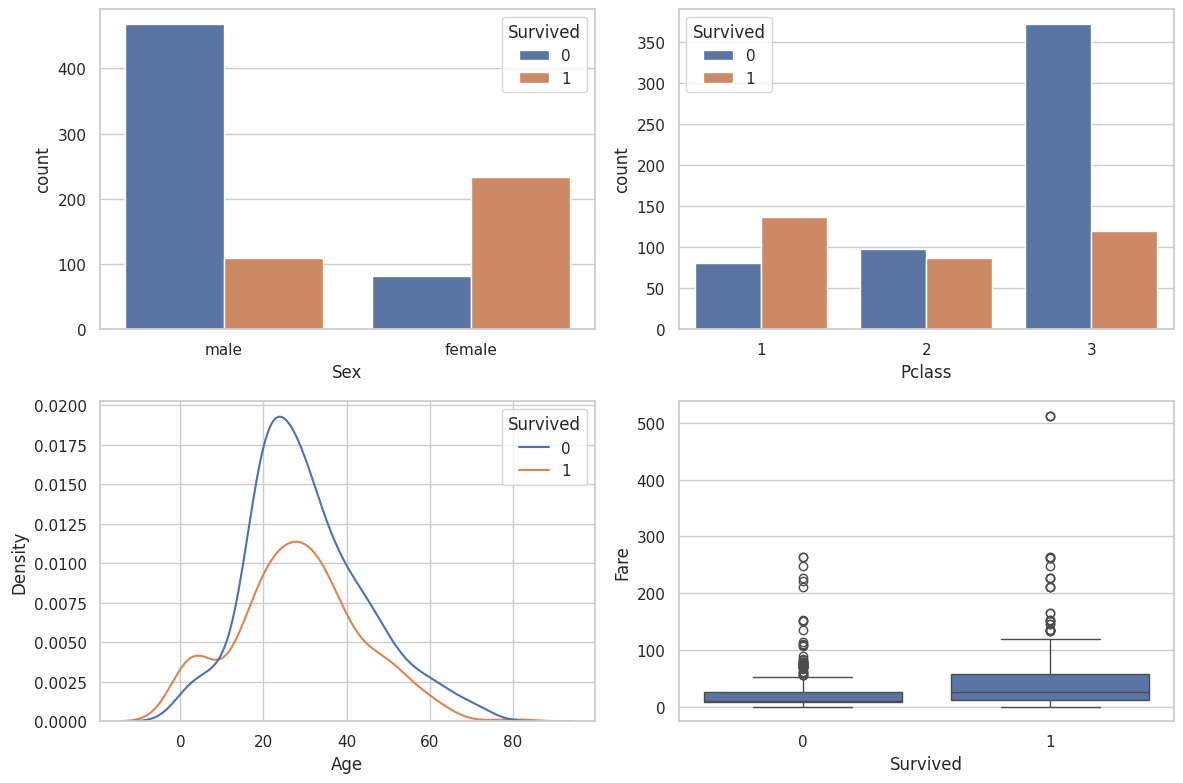

In [50]:
ct_sex = pd.crosstab(train['Sex'], train['Survived'])
chi2_sex, p_sex, _, _ = chi2_contingency(ct_sex)
print("Sex vs Survived — chi2: %.3f p: %.5f" % (chi2_sex, p_sex))

ct_pclass = pd.crosstab(train['Pclass'], train['Survived'])
chi2_pc, p_pc, _, _ = chi2_contingency(ct_pclass)
print("Pclass vs Survived — chi2: %.3f p: %.5f" % (chi2_pc, p_pc))

age_survived = train.loc[train['Survived']==1,'Age'].dropna()
age_dead = train.loc[train['Survived']==0,'Age'].dropna()
stat_age,p_age = mannwhitneyu(age_survived, age_dead)
print("Mann-Whitney Age p=",p_age)

fig,axes = plt.subplots(2,2, figsize=(12,8))
sns.countplot(data=train,x='Sex',hue='Survived',ax=axes[0,0])
sns.countplot(data=train,x='Pclass',hue='Survived',ax=axes[0,1])
sns.kdeplot(data=train,x='Age',hue='Survived',ax=axes[1,0])
sns.boxplot(data=train,x='Survived',y='Fare',ax=axes[1,1])
plt.tight_layout()
plt.show()


# Hipótesis del análisis (versión H0/H1)

**H1. Sexo**
- H0: El sexo del pasajero no afecta la probabilidad de supervivencia.  
- H1: El sexo del pasajero sí afecta la probabilidad de supervivencia.

**H2. Clase (Pclass)**
- H0: La clase socioeconómica no influye en la supervivencia.  
- H1: La clase socioeconómica sí influye en la supervivencia.

**H3. Edad (Age)**
- H0: La edad del pasajero no está asociada con la supervivencia.  
- H1: La edad del pasajero sí está asociada con la supervivencia.

**H4. Tarifa (Fare)**
- H0: La tarifa pagada no afecta la probabilidad de supervivencia.  
- H1: La tarifa pagada sí afecta la probabilidad de supervivencia.

**H5. Puerto de embarque (Embarked)**
- H0: El puerto de embarque no influye en la supervivencia.  
- H1: El puerto de embarque sí influye en la supervivencia.

**H6. Tamaño familiar (FamilySize)**
- H0: El tamaño familiar no está asociado con la supervivencia.  
- H1: El tamaño familiar sí está asociado con la supervivencia.

**H7. Registro de cabina (Cabin / Deck)**
- H0: Tener registro de cabina no afecta la probabilidad de supervivencia.  
- H1: Tener registro de cabina sí afecta la probabilidad de supervivencia.

**H8. Título social (Title)**
- H0: El título social del pasajero no aporta información relevante para predecir la supervivencia.  
- H1: El título social del pasajero sí aporta información relevante.

**H9. Interacción sexo × clase**
- H0: La interacción entre sexo y clase no mejora la explicación de la supervivencia.  
- H1: La interacción entre sexo y clase sí mejora la explicación de la supervivencia.

**H10. Patrón del ticket (Ticket prefix)**
- H0: Los prefijos del ticket no están asociados a la supervivencia.  
- H1: Los prefijos del ticket sí están asociados a la supervivencia.

**H11. Interacción Fare × Pclass**
- H0: La combinación de tarifa y clase no afecta la probabilidad de supervivencia.  
- H1: La combinación de tarifa y clase sí afecta la probabilidad de supervivencia.

**H12. Modelos no lineales**
- H0: Los modelos no lineales no mejoran el rendimiento respecto a modelos lineales.  
- H1: Los modelos no lineales sí mejoran el rendimiento respecto a modelos lineales.

**H13. Estandarización**
- H0: Escalar las variables numéricas no mejora el rendimiento de los modelos sensibles a escala.  
- H1: Escalar las variables numéricas sí mejora el rendimiento de los modelos sensibles a escala.

**H14. Imputación avanzada de edad**
- H0: La imputación avanzada (RF/KNN) no mejora la predicción respecto a imputación simple.  
- H1: La imputación avanzada sí mejora la predicción.

**H15. Features derivadas**
- H0: Las variables creadas (FamilySize, IsAlone, Title, Deck) no incrementan el rendimiento de los modelos.  
- H1: Las variables creadas sí incrementan el rendimiento de los modelos.
